# **Classification of windowed time series without feature extraction**

Here we will make use of the processed data before using feature extraction methods to expand our data into higher dimensional space. 

In the following cells we will use the original features to build and evaluate classifiers for
* binary (Sleep / Wake), 
* three (Sleep / NREM / REM), 
* and multi (Sleep / N1 / N2 / N3 / REM) label classification.

## AutoML

Automated machine learning (AutoML) involves automating the process of applying machine learning end-to-end. It makes ML accessible to non-experts as well as providing a quick and easy way to create model fitted on data without worrying about hyperparameters.

We will use AutoML later on in the notebook but we are installing it here because the runtime must be restarted afterwards.

***Note if you are running this book: run this cell, then restart the notebook's runtime and then run all cells again after. This avoids version errors in auto-sklearn modules.***

In [ ]:
!apt-get install swig -y
!pip install Cython numpy

# sometimes you have to run the next command twice on colab
# I haven't figured out why
!pip install auto-sklearn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


### Mount Drive 





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/CA4015/sleep_classify')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read in our windowed features and their matching labels prepared in our previous data processing


This next part of the notebook involves looking at the interpolated data chunks as independent separate data points with the time element and patient ID removed, and no extracted features. The model performance from this dataset will be a true indicator of how important the time series element is to classifying a patient's sleep state, given only their motion and heart rate for that given window. It's expected that this will result in an impaired model performance compared to the classification of the data with extracted features. Although an improvement would lead to the hypothesis that sleep classification only requires a static model of independent data points.

In [ ]:
import pandas as pd
import numpy as np
# read in our windowed features and matching labels

full_set_features = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/raw_windowed_features.csv')
full_set_true_labels = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/raw_windowed_labels.csv')

# we do not require id and time step columns for this approach
full_set_features = full_set_features.drop(['Unnamed: 0', 'id'], axis=1)
full_set_true_labels = full_set_true_labels.drop(['0', 'id'], axis=1)


Ensure that the unique labels for our data lie in the range 0-5 with unknowns -1 and 4 removed.

In [ ]:
full_set_true_labels["1"].unique()

array([0, 1, 2, 3, 5])

Notice the new dataframe where the order and index of data points are arbitrary and provide no information about the given readings.

In [ ]:
print("Full Set Features", "\n", full_set_features)
print("\nFull Set Labels", "\n", full_set_true_labels)

Full Set Features 
               x         y         z    hr
0     -0.612717 -0.086441 -0.774131  74.5
1     -0.608009 -0.078117 -0.779465  66.5
2     -0.608291 -0.074685 -0.776802  68.0
3     -0.604043 -0.074944 -0.782837  71.0
4     -0.607269 -0.070290 -0.782433  68.0
...         ...       ...       ...   ...
26412 -0.108566 -0.196350 -0.966415  87.0
26413 -0.106613 -0.198547 -0.966125  87.0
26414 -0.108292 -0.198059 -0.967621  87.0
26415 -0.107285 -0.199288 -0.968819  86.5
26416 -0.106293 -0.197815 -0.970017  87.0

[26417 rows x 4 columns]

Full Set Labels 
        1
0      0
1      0
2      0
3      0
4      0
...   ..
26412  2
26413  2
26414  2
26415  2
26416  2

[26417 rows x 1 columns]


Classification models require the target feature set to be in a numpy array. Here we unravel our labels from pandas Series format into a numpy array.

In [ ]:
label_array = full_set_true_labels.values.ravel()
print(label_array.shape)
label_array

(26417,)


array([0, 0, 0, ..., 2, 2, 2])

# Sklearn - Binary Data Classifier

First, we will attempt to classify the data points as being either "Wake" or "Sleep". The next cell will create a dataset which will replace any label greater than 0 with a 1. Now, 0 still represents "Wake", while 1 represents "Sleep".

Let's now implement a simple classifier using our new **binary** dataset.

In [ ]:
# first we'll create a binary label set, indicating 0 for awake and 1 for asleep

binary_label_array = label_array.copy()
binary_label_array[binary_label_array > 0] = 1
np.unique(binary_label_array)

array([0, 1])

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting our data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(full_set_features, binary_label_array, test_size=0.25)

## Support Vector Machine (SVM)

SVMs are a type of supervised learning model that attempts to analyse input data given corresponding labels. SVMs are quite robust but unfortunately training complexity can reach $O(n2p+n3)$ when using non-approximate or non-linear kernels, where $n$ is the number of training examples and $p$ is the number of features.

SVMs work by finding a separating hyperplane between data of different classes. SVM is an algorithm that takes the data as an input and outputs a line that separates those classes as best as it can.

A hyperplane in an n-dimensional Euclidean space is a flat, n-1 dimensional subset of that space that divides the space into two disconnected parts.

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Implementing a C-Support Vector Classifier, 

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [ ]:
clf.score(X_test, y_test, sample_weight=None)

0.9096139288417865

Not a bad score by any means, but as we will see later on, not the best score. Also, accuracy alone is not the best representation of model performance. We would expect the performance to be quite high for binary classification, as a human randomly guessing the label would be 50% accurate.

## Decision Tree Classifier

Let's look at the consistency of our classifier according to this Decision Tree Model. We can see below it is ~90% accurate with 95% confidence interval of 1%.

To train our model we use a technique called Cross Validation; by partitioning the available data into n sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation. A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets. 

The confusion matrix below shows how the decision tree performed on the test set. The top left entry indicates the number of examples correctly labelled "Wake" and the top right is the number of examples incorrectly labelled as "Sleep". Then the bottom left and right indicate the number of examples were incorrectly labelled "Wake" and correctly labelled "Sleep" respectively.

The smaller the values off the diagonal of your confusion matrix are, the better it has performed on the given data.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(random_state=0)  # min_samples_leaf=200

scores = cross_val_score(clf, X_train, y_train, cv=5)
print('The mean score and the 95% confidence interval of the score estimate are given by:')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Training the model in a standard way allows to to view the feature importance
# for this model alone.
clf.fit(X_train,y_train)
importance = (clf.feature_importances_)

# using list comprehension + enumerate() 
# index of matching element 
res = [idx for idx, val in enumerate(importance) if val > 0] 
res_feats = [full_set_features.columns[i] for i in res]
  
# print result 
print("\nThe list of features with importance: ") 

print(res_feats)
print("\nimportance\n", importance)

predictions = clf.predict(X_test)
print("\nTest set accuracy:\n", accuracy_score(y_test, predictions), "\n")
print("Confusion Matrix\n", confusion_matrix(y_test, predictions), "\n")

The mean score and the 95% confidence interval of the score estimate are given by:
Accuracy: 0.91 (+/- 0.01)

The list of features with importance: 
['x', 'y', 'z', 'hr']

importance
 [0.26051276 0.30081511 0.30410366 0.13456847]

Test set accuracy:
 0.9182437547312642 

Confusion Matrix
 [[ 303  304]
 [ 236 5762]] 



## Interpreting our models

The advantage of using more "basic" models like Decision Trees is that they are much easier to interpret than more complex approaches such as neural networks. This is particularly important in real-world scenarios where a model is used to make high-stakes decisions; we want to know **why** a model has made a particular decision when given an input - such as a patient's MRI scan - not just **how**. [A paper published in Nature (Rudin, C., 2019)](https://www.nature.com/articles/s42256-019-0048-x) explores this topic further.

In our case, it's not critical to know why a model has made a classification, but it is interesting to note that Decision Trees perform quite well on this data.

In the below cells we can project the Decision Tree on to an image, which would allow a human to follow the "thought process" of the model from start to classification given an input.

The resulting image from the above tree is far too large to see here, but if we set the parameter min_samples_leaf to a large value such as 200, it would force the tree to stop splitting earlier, making the image simpler and easier to read. However, doing so creates an issue which we will see later on, whereby the model simply guesses that all given inputs are classified as "Sleep", because that is the majority label it is shown in training.

In [ ]:
!pip install graphviz
!pip install imageio
import graphviz
import pydotplus
import io
from scipy import misc
import imageio
import matplotlib.pyplot as plt


def show_tree(tree, path):
    f = io.StringIO()
    export_graphviz(tree, out_file=f)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img = imageio.imread(path)
    plt.rcParams["figure.figsize"] = (30,20)
    plt.imshow(img)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.488491 to fit



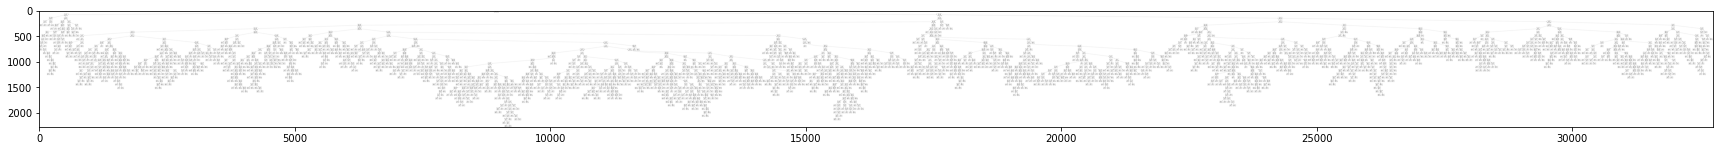

In [ ]:
show_tree(clf, "binary_dec_tree.png")

## Comparing Classification Algorithms

When comparing the different algorithms for classifying our sleep stages, we must also look at how these algorithms choose a label. As shown below, all algorithms initially look very effective at classifying data, with all achieving accuracy of $>= 90%$. 

However, a closer inspection reveals that some algorithms are simply guessing every datapoint is in "Sleep" stage, because, for the majority of our points, this is true.

In [ ]:
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

def algorithm_comparison(X_train, y_train, X_test, y_test, n_splits=10):
    models = []
    models.append(("LOGISTIC REGRESSION", LogisticRegression(max_iter=1000)))
    models.append(("LINEAR DISCRIMINANT AANALYSIS", LinearDiscriminantAnalysis()))
    models.append(("K NEAREST NEIGHBOURS", KNeighborsClassifier()))
    models.append(("NAIVE BAYES", GaussianNB()))
    models.append(("DECISION TREE", DecisionTreeClassifier()))
    models.append(("RANDOM FOREST", RandomForestClassifier()))
    models.append(("SUPPORT VECTOR MACHINE", SVC()))
    models.append(("ADABOOST CLASSIFIER", AdaBoostClassifier()))

    results = []
    names = []

    for name, model in models:
      kfold = model_selection.KFold(n_splits=n_splits)
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
      results.append(cv_results)
      names.append(name)
      print("Model  Mean Accuracy  95% conf interval")
      msg = "{}: {} {}\n".format(name, cv_results.mean(), cv_results.std() * 2)
      print(msg)

      model.fit(X_train, y_train)
      predictions = model.predict(X_test)
      print("Test set accuracy:\n", accuracy_score(y_test, predictions), "\n")
      print("Confusion Matrix\n", confusion_matrix(y_test, predictions), "\n")
      print("Classification report\n" ,classification_report(y_test, predictions), "\n")

    return names, results


In [ ]:
names, results = algorithm_comparison(X_train, y_train, X_test, y_test)

Model  Mean Accuracy  95% conf interval
LOGISTIC REGRESSION: 0.9080355200845979 0.011057478757985417

Test set accuracy:
 0.9080999242997729 

Confusion Matrix
 [[   0  607]
 [   0 5998]] 

Classification report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       607
           1       0.91      1.00      0.95      5998

    accuracy                           0.91      6605
   macro avg       0.45      0.50      0.48      6605
weighted avg       0.82      0.91      0.86      6605
 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
LINEAR DISCRIMINANT AANALYSIS: 0.9080355200845979 0.011057478757985417

Test set accuracy:
 0.9080999242997729 

Confusion Matrix
 [[   0  607]
 [   0 5998]] 

Classification report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       607
           1       0.91      1.00      0.95      5998

    accuracy                           0.91      6605
   macro avg       0.45      0.50      0.48      6605
weighted avg       0.82      0.91      0.86      6605
 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
K NEAREST NEIGHBOURS: 0.906672623016538 0.013060781303140236

Test set accuracy:
 0.9094625283875851 

Confusion Matrix
 [[ 107  500]
 [  98 5900]] 

Classification report
               precision    recall  f1-score   support

           0       0.52      0.18      0.26       607
           1       0.92      0.98      0.95      5998

    accuracy                           0.91      6605
   macro avg       0.72      0.58      0.61      6605
weighted avg       0.89      0.91      0.89      6605
 

Model  Mean Accuracy  95% conf interval
NAIVE BAYES: 0.9083888769750572 0.011097381149822732

Test set accuracy:
 0.9084027252081757 

Confusion Matrix
 [[   7  600]
 [   5 5993]] 

Classification report
               precision    recall  f1-score   support

           0       0.58      0.01      0.02       607
           1       0.91      1.00      0.95      5998

    accuracy                           0.91      6605
   macro avg       0.75      0.51  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
ADABOOST CLASSIFIER: 0.9082878923944986 0.011041406441707589

Test set accuracy:
 0.9082513247539743 

Confusion Matrix
 [[   7  600]
 [   6 5992]] 

Classification report
               precision    recall  f1-score   support

           0       0.54      0.01      0.02       607
           1       0.91      1.00      0.95      5998

    accuracy                           0.91      6605
   macro avg       0.72      0.51      0.49      6605
weighted avg       0.87      0.91      0.87      6605
 



## Plotting Algorithm Performance

In [ ]:
import matplotlib.pyplot as plt

def plot_algo_comparison(names, results, title="Algorithm Comparison"):
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(title)
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

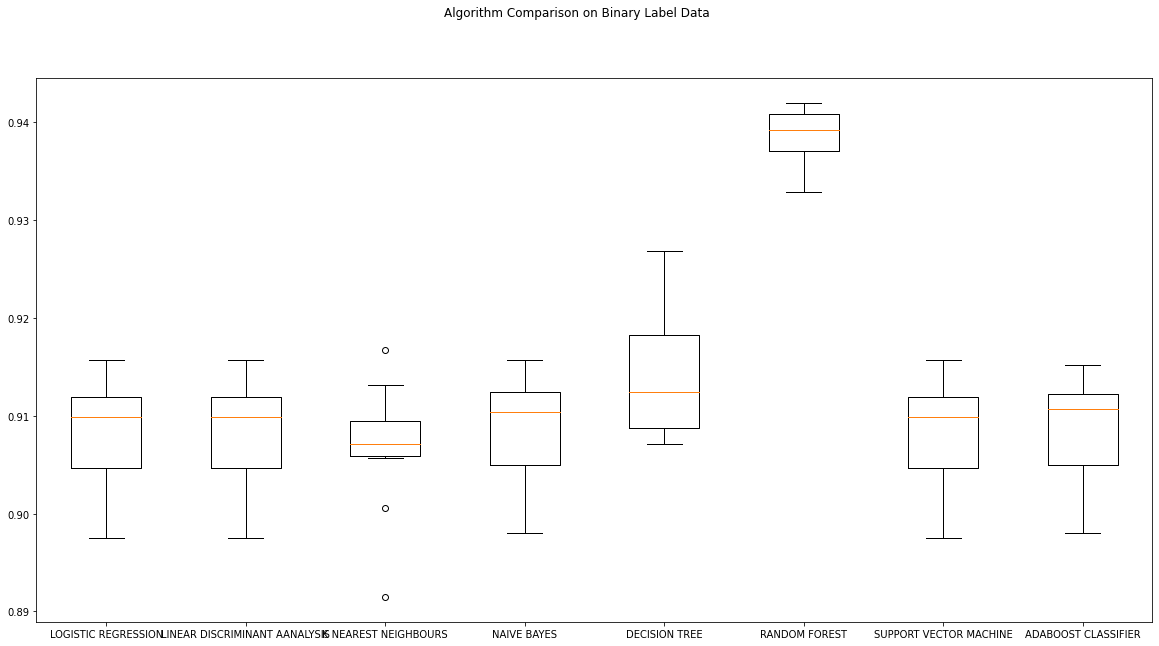

In [ ]:
plot_algo_comparison(names, results, title="Algorithm Comparison on Binary Label Data")

The Decision Tree, and by extension the Random Forest algorithm, appear to be the best performing models for the binary classification.

## AutoML

Automated machine learning (AutoML) involves automating the process of applying machine learning end-to-end. It makes ML accessible to non-experts as well as providing a quick and easy way to create model fitted on data without worrying about hyperparameters.

In [ ]:
try:
    import autosklearn.classification
except:
    os.kill(os.getpid(), 9)
import sklearn

# configure auto-sklearn
automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          )

# train model(s)
automl.fit(X_train, y_train)

# evaluate
y_hat = automl.predict(X_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_hat)
print("Test Accuracy score {0}".format(test_acc))

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Test Accuracy score 0.9356548069644209


Using AutoML yields an impressive test accuracy of ~0.93, but is still outperformed slightly by the sklearn RF.

## Nested Cross Validation

We intended to include the nested cross validation through sklearn but it appears to be very computationally expensive when applied to this data, and ends up running for too long with no result.

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def nested_cross_val(X_train, y_train, model=KNeighborsClassifier()):

    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

    # define search space
    pgrid = {"n_neighbors": [2, 5, 10, 30],
              "weights": ["uniform", "distance"],
              "algorithm": ["auto", "ball_tree", "kd_tree"],
              "leaf_size": [15, 30],
              "p": [1, 2, 4],
              }

    # define search
    search = GridSearchCV(model, pgrid, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
    # execute the nested cross-validation
    scores = cross_val_score(search, X_train, y_train, scoring='accuracy', cv=cv_outer, n_jobs=-1)
    # report performance
    print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
#nested_cross_val(X_train, y_train)

# Sklearn - Three-Label Data Classifier

Let's now implement classifiers using a **WAKE / NREM / REM label** dataset.

First we'll create a three label set, indicating 0 for awake, 1 for non-REM sleep and 2 for REM sleep

In [ ]:
three_label_array = label_array.copy()
three_label_array[(three_label_array == 1) | (three_label_array == 2) | (three_label_array == 3)] = 1
three_label_array[three_label_array == 5] = 2

np.unique(three_label_array)

array([0, 1, 2])

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting our data into training and testing.

X_train, X_test, y_train, y_test = train_test_split(full_set_features, three_label_array, test_size=0.25)

## Decision Tree Classifier

Let's look at the feature importance according to this Decision Tree Model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

scores = cross_val_score(clf, X_train, y_train, cv=5)
print('The mean score and the 95% confidence interval of the score estimate are given by:')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Training the model in a standard way allows to to view the feature importance
# for this model alone.
clf.fit(X_train,y_train)
importance = (clf.feature_importances_)

# index of matching element 
res = [idx for idx, val in enumerate(importance) if val > 0] 
res_feats = [full_set_features.columns[i] for i in res]
  
# print result 
print("\nThe list of features with importance: ") 

print(res_feats)
print("importance\n", importance)

The mean score and the 95% confidence interval of the score estimate are given by:
Accuracy: 0.83 (+/- 0.01)

The list of features with importance: 
['x', 'y', 'z', 'hr']
importance
 [0.29920924 0.29638919 0.26554737 0.13885419]


## Nested Cross Validation

In [ ]:
#nested_cross_val(X_train, y_train)

## Comparing Classification Algorithms

In [ ]:
names, results = algorithm_comparison(X_train, y_train, X_test, y_test)

Model  Mean Accuracy  95% conf interval
LOGISTIC REGRESSION: 0.6854437030701859 0.015297374696694597

Test set accuracy:
 0.6850870552611658 

Confusion Matrix
 [[   0  601    0]
 [   0 4525    0]
 [   2 1477    0]] 

Classification report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       601
           1       0.69      1.00      0.81      4525
           2       0.00      0.00      0.00      1479

    accuracy                           0.69      6605
   macro avg       0.23      0.33      0.27      6605
weighted avg       0.47      0.69      0.56      6605
 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
LINEAR DISCRIMINANT AANALYSIS: 0.6854941826259658 0.015281281751026958

Test set accuracy:
 0.6852384557153671 

Confusion Matrix
 [[   1  600    0]
 [   0 4525    0]
 [   2 1477    0]] 

Classification report
               precision    recall  f1-score   support

           0       0.33      0.00      0.00       601
           1       0.69      1.00      0.81      4525
           2       0.00      0.00      0.00      1479

    accuracy                           0.69      6605
   macro avg       0.34      0.33      0.27      6605
weighted avg       0.50      0.69      0.56      6605
 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
K NEAREST NEIGHBOURS: 0.7061881517198451 0.01681505220940768

Test set accuracy:
 0.7200605601816805 

Confusion Matrix
 [[ 149  361   91]
 [ 182 4037  306]
 [ 104  805  570]] 

Classification report
               precision    recall  f1-score   support

           0       0.34      0.25      0.29       601
           1       0.78      0.89      0.83      4525
           2       0.59      0.39      0.47      1479

    accuracy                           0.72      6605
   macro avg       0.57      0.51      0.53      6605
weighted avg       0.69      0.72      0.70      6605
 

Model  Mean Accuracy  95% conf interval
NAIVE BAYES: 0.6859987744317738 0.014689180863305543

Test set accuracy:
 0.6852384557153671 

Confusion Matrix
 [[  10  591    0]
 [   9 4516    0]
 [   4 1475    0]] 

Classification report
               precision    recall  f1-score   support

           0       0.43      0.02      0.03       601
           1       0.69      1.00 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
DECISION TREE: 0.839996770530942 0.014203204179065735

Test set accuracy:
 0.8457229371688115 

Confusion Matrix
 [[ 325  205   71]
 [ 177 4099  249]
 [  78  239 1162]] 

Classification report
               precision    recall  f1-score   support

           0       0.56      0.54      0.55       601
           1       0.90      0.91      0.90      4525
           2       0.78      0.79      0.78      1479

    accuracy                           0.85      6605
   macro avg       0.75      0.74      0.75      6605
weighted avg       0.84      0.85      0.85      6605
 

Model  Mean Accuracy  95% conf interval
RANDOM FOREST: 0.8787100818013307 0.011076220791087055

Test set accuracy:
 0.8859954579863739 

Confusion Matrix
 [[ 305  234   62]
 [  72 4300  153]
 [  23  209 1247]] 

Classification report
               precision    recall  f1-score   support

           0       0.76      0.51      0.61       601
           1       0.91      0.95      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
ADABOOST CLASSIFIER: 0.690995588260014 0.015710790450869275

Test set accuracy:
 0.6912944738834217 

Confusion Matrix
 [[  18  570   13]
 [   9 4497   19]
 [   5 1423   51]] 

Classification report
               precision    recall  f1-score   support

           0       0.56      0.03      0.06       601
           1       0.69      0.99      0.82      4525
           2       0.61      0.03      0.07      1479

    accuracy                           0.69      6605
   macro avg       0.62      0.35      0.31      6605
weighted avg       0.66      0.69      0.58      6605
 



## Plotting Algorithm Performance

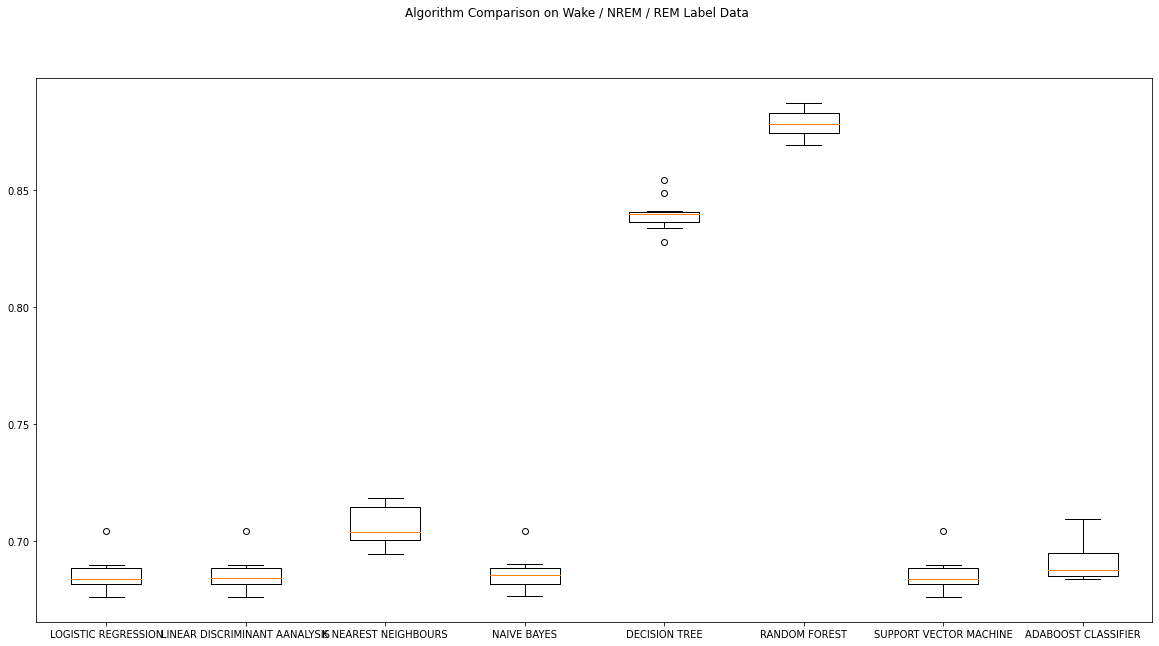

In [ ]:
plot_algo_comparison(names, results, title="Algorithm Comparison on Wake / NREM / REM Label Data")

Again, Random Forest and Decision Tree outperform the other algorithms with an accuracy of ~0.85, with the rest of the models displaying accuracy of ~0.7

## AutoML

In [ ]:
import autosklearn.classification
import sklearn
# configure auto-sklearn
automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          )

# train model(s)
automl.fit(X_train, y_train)

# evaluate
y_hat = automl.predict(X_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_hat)
print("Test Accuracy score {0}".format(test_acc))

Test Accuracy score 0.8788796366389099


# Sklearn - Multi-Label Data Classifier

Let's now implement a simple multiclass classifier using our **original multi-label** dataset

In [ ]:
np.unique(label_array)

array([0, 1, 2, 3, 5])

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting our data into training and testing.
# Please don't ever train on your test data, that's a big no no!
X_train, X_test, y_train, y_test = train_test_split(full_set_features, label_array, test_size=0.25)

## Decision Tree Classifier

Let's look at the feature importance according to this Decision Tree Model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

scores = cross_val_score(clf, X_train, y_train, cv=5)
print('The mean score and the 95% confidence interval of the score estimate are given by:')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Training the model in a standard way allows to to view the feature importance
# for this model alone.
clf.fit(X_train,y_train)
importance = (clf.feature_importances_)

# using list comprehension + enumerate() 
# index of matching element 
res = [idx for idx, val in enumerate(importance) if val > 0] 
res_feats = [full_set_features.columns[i] for i in res]
  
# print result 
print("\nThe list of features with importance: ") 

print(res_feats)
print("importance\n", importance)

The mean score and the 95% confidence interval of the score estimate are given by:
Accuracy: 0.73 (+/- 0.01)

The list of features with importance: 
['x', 'y', 'z', 'hr']
importance
 [0.28835684 0.31187007 0.24885919 0.15091391]


## Nested Cross Validation

In [ ]:
#nested_cross_val(X_train, y_train)

## Comparing Classification Algorithms

In [ ]:
names, results = algorithm_comparison(X_train, y_train, X_test, y_test)

Model  Mean Accuracy  95% conf interval
LOGISTIC REGRESSION: 0.4886423801085081 0.01715752324924274

Test set accuracy:
 0.48962906888720664 

Confusion Matrix
 [[   1    0  569   10    3]
 [   0    0  453    2    0]
 [   0    0 3223   12   10]
 [   0    0  836    2    0]
 [   0    0 1476    0    8]] 

Classification report
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       583
           1       0.00      0.00      0.00       455
           2       0.49      0.99      0.66      3245
           3       0.08      0.00      0.00       838
           5       0.38      0.01      0.01      1484

    accuracy                           0.49      6605
   macro avg       0.39      0.20      0.14      6605
weighted avg       0.43      0.49      0.33      6605
 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
LINEAR DISCRIMINANT AANALYSIS: 0.4890966197035307 0.016960005628748605

Test set accuracy:
 0.48962906888720664 

Confusion Matrix
 [[   1    0  568   11    3]
 [   0    0  453    2    0]
 [   0    0 3223   12   10]
 [   0    0  836    2    0]
 [   0    0 1476    0    8]] 

Classification report
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       583
           1       0.00      0.00      0.00       455
           2       0.49      0.99      0.66      3245
           3       0.07      0.00      0.00       838
           5       0.38      0.01      0.01      1484

    accuracy                           0.49      6605
   macro avg       0.39      0.20      0.14      6605
weighted avg       0.42      0.49      0.33      6605
 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
K NEAREST NEIGHBOURS: 0.5772768648273635 0.03133879733818633

Test set accuracy:
 0.5887963663890992 

Confusion Matrix
 [[ 175   34  247   46   81]
 [  56   46  253   31   69]
 [ 134   91 2578  174  268]
 [  20    7  269  513   29]
 [ 104   38  643  122  577]] 

Classification report
               precision    recall  f1-score   support

           0       0.36      0.30      0.33       583
           1       0.21      0.10      0.14       455
           2       0.65      0.79      0.71      3245
           3       0.58      0.61      0.60       838
           5       0.56      0.39      0.46      1484

    accuracy                           0.59      6605
   macro avg       0.47      0.44      0.45      6605
weighted avg       0.56      0.59      0.57      6605
 

Model  Mean Accuracy  95% conf interval
NAIVE BAYES: 0.4879863496353603 0.016979299637552656

Test set accuracy:
 0.48932626797880396 

Confusion Matrix
 [[  27    0  556    0    0]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
DECISION TREE: 0.7357655802780299 0.018385583234761665

Test set accuracy:
 0.7483724451173354 

Confusion Matrix
 [[ 308   82  109   19   65]
 [  71  125  195    8   56]
 [ 103  148 2704  140  150]
 [  18    6  125  674   15]
 [  68   65  196   23 1132]] 

Classification report
               precision    recall  f1-score   support

           0       0.54      0.53      0.54       583
           1       0.29      0.27      0.28       455
           2       0.81      0.83      0.82      3245
           3       0.78      0.80      0.79       838
           5       0.80      0.76      0.78      1484

    accuracy                           0.75      6605
   macro avg       0.65      0.64      0.64      6605
weighted avg       0.75      0.75      0.75      6605
 

Model  Mean Accuracy  95% conf interval
RANDOM FOREST: 0.7943170004039383 0.016357184160300964

Test set accuracy:
 0.8078728236184709 

Confusion Matrix
 [[ 330   52  123   16   62]
 [  4

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
ADABOOST CLASSIFIER: 0.5090853776874251 0.021948714174575758

Test set accuracy:
 0.5064345193035579 

Confusion Matrix
 [[  40    1  519    6   17]
 [  14    0  429    1   11]
 [  16    0 3176   25   28]
 [   0    0  769   28   41]
 [  16    0 1344   23  101]] 

Classification report
               precision    recall  f1-score   support

           0       0.47      0.07      0.12       583
           1       0.00      0.00      0.00       455
           2       0.51      0.98      0.67      3245
           3       0.34      0.03      0.06       838
           5       0.51      0.07      0.12      1484

    accuracy                           0.51      6605
   macro avg       0.36      0.23      0.19      6605
weighted avg       0.45      0.51      0.37      6605
 



## Plotting Algorithm Performance

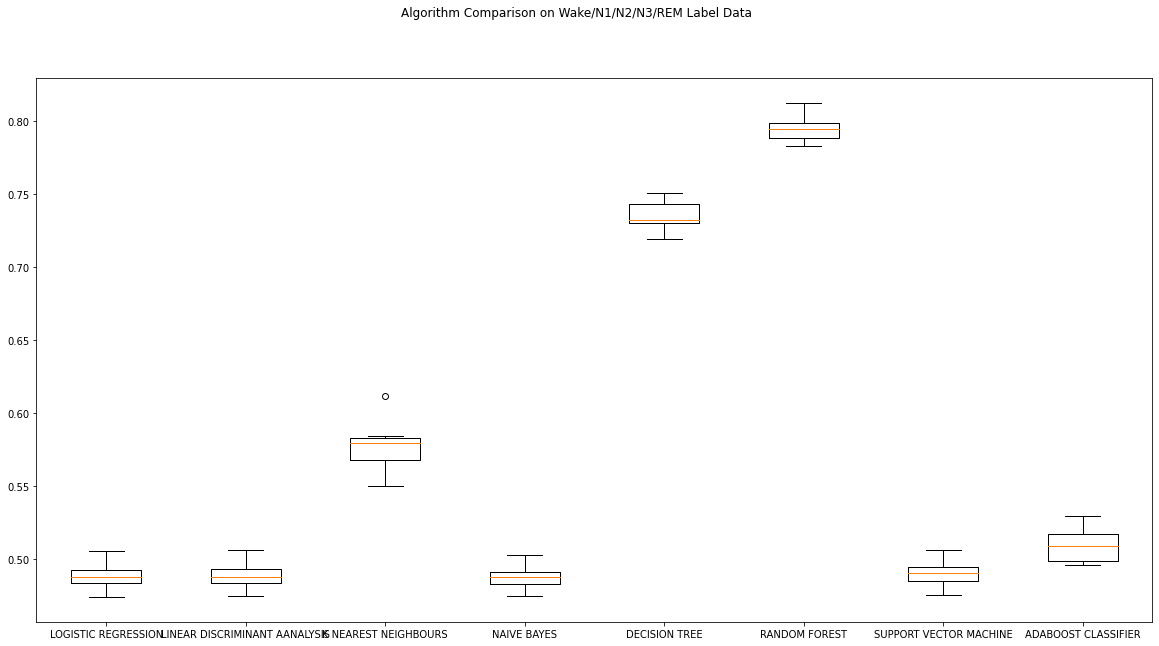

In [ ]:
plot_algo_comparison(names, results, title="Algorithm Comparison on Wake/N1/N2/N3/REM Label Data")

The addition of more labels again inhibits model performance and is penalising the algorithms which primarily guess the most frequent training label. RF and DT execute the highest accuracy of ~0.8 and ~0.75 respectively.

## AutoML

In [ ]:
import autosklearn.classification
import sklearn
# configure auto-sklearn
automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          )

# train model(s)
automl.fit(X_train, y_train)

# evaluate
y_hat = automl.predict(X_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_hat)
print("Test Accuracy score {0}".format(test_acc))

Test Accuracy score 0.7943981831945496


The ensemble AutoML algorithm continues to compete with the best performing sklearn algorithm for all label sets.

# **Classification of Windowed Time Series Data with Extracted features**

We will now be performing classification on the extracted feature dataset and observing the model results. This is time series classification as the time and ID columns are now included and the many extra features that TSFresh has provided have encoded information in each row about the time series. We can now treat it like any normal non-time series dataset while still being sure the time series information is retained for our analysis and classification. 

Again, we will perform classification with the three different label sets of Binary: Wake/Sleep, Three classes: Wake, Non-REM Sleep and REM Sleep and finally with all original labels of sleep classes: (0, 1, 2, 3, 5). 

In [ ]:
import pandas as pd
import numpy as np

extracted_features = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/extracted_features.csv')
extracted_labels = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/extracted_features_labels.csv')

extracted_features = extracted_features.rename(columns={'Unnamed: 0': 'id', 'Unnamed: 1': 'time'})

extracted_features.head()

,id,time,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,value__mean,value__length,value__standard_deviation,value__variation_coefficient,value__variance,value__skewness,value__kurtosis,value__absolute_sum_of_changes,value__longest_strike_below_mean,value__longest_strike_above_mean,value__count_above_mean,value__count_below_mean,value__last_location_of_maximum,value__first_location_of_maximum,value__last_location_of_minimum,value__first_location_of_minimum,value__percentage_of_reoccurring_values_to_all_values,value__percentage_of_reoccurring_datapoints_to_all_datapoints,value__sum_of_reoccurring_values,value__sum_of_reoccurring_data_points,value__ratio_value_number_to_time_series_length,value__maximum,value__minimum,value__benford_correlation,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__c3__lag_1,...,"value__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","value__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","value__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",value__number_crossing_m__m_0,value__number_crossing_m__m_-1,value__number_crossing_m__m_1,value__energy_ratio_by_chunks__num_segments_10__segment_focus_0,value__energy_ratio_by_chunks__num_segments_10__segment_focus_1,value__energy_ratio_by_chunks__num_segments_10__segment_focus_2,value__energy_ratio_by_chunks__num_segments_10__segment_focus_3,value__energy_ratio_by_chunks__num_segments_10__segment_focus_4,value__energy_ratio_by_chunks__num_segments_10__segment_focus_5,value__energy_ratio_by_chunks__num_segments_10__segment_focus_6,value__energy_ratio_by_chunks__num_segments_10__segment_focus_7,value__energy_ratio_by_chunks__num_segments_10__segment_focus_8,value__energy_ratio_by_chunks__num_segments_10__segment_focus_9,value__ratio_beyond_r_sigma__r_0.5,value__ratio_beyond_r_sigma__r_1,value__ratio_beyond_r_sigma__r_1.5,value__ratio_beyond_r_sigma__r_2,value__ratio_beyond_r_sigma__r_2.5,value__ratio_beyond_r_sigma__r_3,value__ratio_beyond_r_sigma__r_5,value__ratio_beyond_r_sigma__r_6,value__ratio_beyond_r_sigma__r_7,value__ratio_beyond_r_sigma__r_10,value__count_above__t_0,value__count_below__t_0,value__lempel_ziv_complexity__bins_2,value__lempel_ziv_complexity__bins_3,value__lempel_ziv_complexity__bins_5,value__lempel_ziv_complexity__bins_10,value__lempel_ziv_complexity__bins_100,value__fourier_entropy__bins_2,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1
0,46343,390.0,1.0,0.0,0.0,0.0,89.910614,8100.838344,30.793696,30.186508,22.242584,0.235069,22.477653,4.0,38.986724,1.734466,1519.964679,1.999177,3.997235,92.381088,3.0,1.0,1.0,3.0,1.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,1.0,90.0,-0.559524,-0.220047,-892.340880,0.0,0.0,-6.802985,...,-0.286355,0.927415,0.0,3.0,0.0,1.0,0.000039,0.000059,0.000006,0.999897,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.50,0.75,0.75,0.75,0.75,1.0,0.636514,1.098612,1.098612,1.098612,1.098612,0.693147,-0.0
1,46343,420.0,1.0,0.0,0.0,0.0,100.727615,10201.949516,34.534958,33.877009,25.002583,0.179321,25.181904,4.0,43.776239,1.738401,1916.359096,1.999278,3.997573,103.604874,3.0,1.0,1.0,3.0,1.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,1.0,101.0,-0.631027,0.240954,-1602.303277,0.0,0.0,-10.606410,...,-0.318167,0.922892,0.0,3.0,0.0,1.0,0.000039,0.000044,0.000010,0.999907,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.50,0.75,0.75,0.75,0.75,1.0,0.636514,1.098612,1.098612,1.098612,1.098612,0.693147,-0.0
2,46343,450.0,1.0,0.0,0.0,0.0,93.513177,8465.342833,30.757888,30.705180,22.563936,0.814358,23.378294,4.

# PCA of Extracted Features

Principal Component Analysis is often used in ML when the number of dimensions is very high. The much smaller number of Principal Components capture the majority of the variance in the original dataset, and thus can be used to train the model instead. The smaller number of dimensions with PCA means faster training times and simplified data structure when feeding into ML models.

Conversely, the Principal Components created from reducing the original dimensions have no interpretability to the user, as we cannot trace back what makes up each PC. Therefore, any model created using PCA will not be very transparent, making it a poor choice for solving real-world high-stakes problems.

In [ ]:
feats = extracted_features.columns[2:]
feats

Index(['value__variance_larger_than_standard_deviation',
       'value__has_duplicate_max', 'value__has_duplicate_min',
       'value__has_duplicate', 'value__sum_values', 'value__abs_energy',
       'value__mean_abs_change', 'value__mean_change',
       'value__mean_second_derivative_central', 'value__median',
       ...
       'value__lempel_ziv_complexity__bins_5',
       'value__lempel_ziv_complexity__bins_10',
       'value__lempel_ziv_complexity__bins_100',
       'value__fourier_entropy__bins_2', 'value__fourier_entropy__bins_3',
       'value__fourier_entropy__bins_5', 'value__fourier_entropy__bins_10',
       'value__fourier_entropy__bins_100',
       'value__permutation_entropy__dimension_3__tau_1',
       'value__permutation_entropy__dimension_4__tau_1'],
      dtype='object', length=269)

In [ ]:
from scipy import stats

standardised = stats.zscore(extracted_features[feats])

details = extracted_features.columns[:2]
df1_std = pd.DataFrame(standardised, columns = feats)
df1_std = df1_std.dropna(axis='columns')
#df1_std = pd.concat([extracted_features[details], df1_std], axis=1)
df1_std

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,value__mean,value__standard_deviation,value__variation_coefficient,value__variance,value__skewness,value__kurtosis,value__absolute_sum_of_changes,value__last_location_of_minimum,value__first_location_of_minimum,value__maximum,value__minimum,value__benford_correlation,value__time_reversal_asymmetry_statistic__lag_1,value__c3__lag_1,value__cid_ce__normalize_True,value__cid_ce__normalize_False,value__quantile__q_0.1,value__quantile__q_0.2,value__quantile__q_0.3,value__quantile__q_0.4,value__quantile__q_0.6,value__quantile__q_0.7,value__quantile__q_0.8,value__quantile__q_0.9,value__autocorrelation__lag_1,value__autocorrelation__lag_2,value__autocorrelation__lag_3,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40",value__partial_autocorrelation__lag_1,value__number_cwt_peaks__n_1,value__number_peaks__n_1,value__binned_entropy__max_bins_10,...,"value__fft_coefficient__attr_""abs""__coeff_0","value__fft_coefficient__attr_""abs""__coeff_1","value__fft_coefficient__attr_""abs""__coeff_2","value__fft_coefficient__attr_""angle""__coeff_1","value__fft_aggregated__aggtype_""centroid""","value__fft_aggregated__aggtype_""variance""","value__fft_aggregated__aggtype_""skew""","value__fft_aggregated__aggtype_""kurtosis""",value__value_count__value_0,value__value_count__value_1,value__range_count__max_1__min_-1,value__range_count__max_1000000000000.0__min_0,value__friedrich_coefficients__coeff_0__m_3__r_30,value__friedrich_coefficients__coeff_1__m_3__r_30,value__friedrich_coefficients__coeff_2__m_3__r_30,value__friedrich_coefficients__coeff_3__m_3__r_30,value__max_langevin_fixed_point__m_3__r_30,"value__linear_trend__attr_""pvalue""","value__linear_trend__attr_""rvalue""","value__linear_trend__attr_""intercept""","value__linear_trend__attr_""slope""","value__linear_trend__attr_""stderr""","value__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","value__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""",value__number_crossing_m__m_0,value__number_crossing_m__m_-1,value__number_crossing_m__m_1,value__energy_ratio_by_chunks__num_segments_10__segment_focus_0,value__energy_ratio_by_chunks__num_segments_10__segment_focus_1,value__energy_ratio_by_chunks__num_segments_10__segment_focus_2,value__energy_ratio_by_chunks__num_segments_10__segment_focus_3,value__count_above__t_0,value__count_below__t_0,value__lempel_ziv_complexity__bins_2,value__lempel_ziv_complexity__bins_100,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1
0,2.575756,2.821527,2.563929,2.574612,2.389934,0.678840,2.575756,2.515752,-0.835504,2.795317,0.709471,0.700269,2.563929,-2.485073,-2.485073,2.533013,0.825217,-0.621031,0.082009,-0.582327,-0.203491,2.501582,0.665751,0.371718,0.079868,0.291610,0.936568,2.677247,2.577357,2.546539,-0.025365,0.813961,-1.494746,-1.054467,0.813961,1.395581,-0.025365,0.780527,1.013760,-1.0,...,2.575756,2.463885,2.602619,0.800593,-0.076038,1.260173,0.074574,-0.158207,-0.006153,-0.006153,0.077322,0.009425,0.017373,-0.006344,-0.012000,0.005699,0.007450,-0.798195,0.798195,-2.510599,2.560623,2.438505,0.029030,1.061956,1.294470,-0.063096,-0.018211,0.099459,0.020001,-1.649423,1.898409,0.009425,-0.009477,1.509692,0.695654,1.0,1.0,1.0,1.0,0.243792
1,3.639897,4.361842,3.667110,3.670183,3.483406,0.486899,3.639897,3.611803,-0.697872,4.340198,0.850319,0.842304,3.667110,-2.485073,-2.485073,3.621965,0.531841,1.075842,-0.403956,-1.029758,-0.193166,3.596822,0.296412,-0.018904,-0.274987,0.002243,0.838773,3.673564,3.657761,3.633384,-0.019141,0.751283,-1.388319,-0.981523,0.751283,1.291465,-0.019141,0.780527,1.013760,-1.0,...,3.639897,3.558150,3.695714,0.745423,-0.018201,1.122919,0.016814,-0.0926

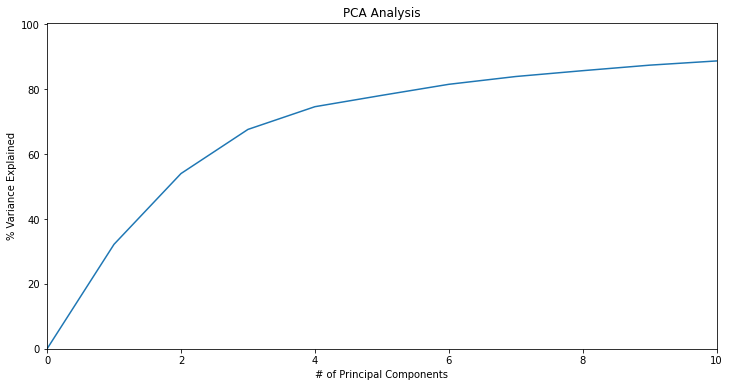

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# use this function to find variance captured in n PCs
# ideally we'd like 75-90% variance captured in 2 or 3 PCs
# to give an accurate representation of the original data

def ideal_pca(df_std):
    dims = 10 # or use len(df_std.columns)
    pca = PCA(n_components = dims)
    pca.fit(df_std)
    variance = pca.explained_variance_ratio_
    variance = np.insert(variance, 0, 0, axis=0)
    var = np.cumsum(np.round(variance, 3)*100)
    plt.figure(figsize=(12,6))
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Principal Components')
    plt.title('PCA Analysis')
    plt.ylim(0,100.5)
    plt.xlim(0, dims)
    plt.plot(var)
    
ideal_pca(df1_std)

In [ ]:
pca3 = PCA(n_components = 5).fit(df1_std)
pca3d = pca3.transform(df1_std)
pca3d_df = pd.DataFrame(pca3d)

print(pca3.explained_variance_ratio_)
print("\nTotal variance captured:\n")
print(sum(pca3.explained_variance_ratio_))

# the % variance captured by our PCs

[0.32182321 0.21781189 0.13619469 0.0699446  0.0350436 ]

Total variance captured:

0.7808179870194095


In [ ]:
pca3d_df

,0,1,2,3,4
0,16.479781,2.196632,0.555395,-4.694193,1.827663
1,23.148063,1.351246,-0.376630,-4.838082,1.933818
2,18.213829,7.570060,5.841912,-3.278936,6.812912
3,11.664291,9.782295,-2.254102,-3.964441,3.505594
4,12.299023,9.864997,-2.051454,-3.971385,3.628099
...,...,...,...,...,...
26412,3.462305,-4.156793,-2.779734,-1.325572,0.161441
26413,5.243921,-3.735498,0.654760,-1.911027,-1.356353
26414,1.330057,-3.492736,0.889212,-2.119469,-1.253958
26415,1.926167,-3.536070,0.846977,-2.105734,-1.295859


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting our data into training and testing.
X_train, X_test, y_train, y_test = train_test_split(pca3d_df, e_label_array, test_size=0.25)

## Decision Tree Classifier

Let's look at the feature importance according to this Decision Tree Model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

scores = cross_val_score(clf, X_train, y_train, cv=5)
print('The mean score and the 95% confidence interval of the score estimate are given by:')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Training the model in a standard way allows to to view the feature importance
# for this model alone.
clf.fit(X_train,y_train)
importance = (clf.feature_importances_)

# using list comprehension + enumerate() 
# index of matching element 
res = [idx for idx, val in enumerate(importance) if val > 0] 
res_feats = [extracted_features.columns[i] for i in res]
  
# print result 
print("\nThe list of features with importance: ") 

print(res_feats)
print("importance\n", importance)

The mean score and the 95% confidence interval of the score estimate are given by:
Accuracy: 0.69 (+/- 0.01)

The list of features with importance: 
['id', 'time', 'value__variance_larger_than_standard_deviation', 'value__has_duplicate_max', 'value__has_duplicate_min']
importance
 [0.16368477 0.15996109 0.24157696 0.2176182  0.21715897]


## AutoML

In [ ]:
import autosklearn.classification
import sklearn
# configure auto-sklearn
automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          )

# train model(s)
automl.fit(X_train, y_train)

# evaluate
y_hat = automl.predict(X_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_hat)
print("Test Accuracy score {0}".format(test_acc))

Test Accuracy score 0.7309613928841786


We decided that for our situation, with training not taking particularly long without PCA and losing more than 20% of the variance with PCA, it wasn't the right way to go and instead we would continue to simply use the full amount of features. Interestingly we also

# Binary Data Classifier

In [ ]:
# first we'll create a binary label set, indicating 0 for awake and 1 for asleep

e_binary_label_array = extracted_labels['1'].ravel().copy()
e_binary_label_array[e_binary_label_array > 0] = 1
print(np.unique(e_binary_label_array))
print(e_binary_label_array.shape)

[0 1]
(26417,)


In [ ]:
print("Extracted Features", "\n", extracted_features)
print("\nExtracted Labels", "\n", e_binary_label_array)

Extracted Features 
             id  ...  value__permutation_entropy__dimension_4__tau_1
0        46343  ...                                            -0.0
1        46343  ...                                            -0.0
2        46343  ...                                            -0.0
3        46343  ...                                            -0.0
4        46343  ...                                            -0.0
...        ...  ...                                             ...
26412  9961348  ...                                            -0.0
26413  9961348  ...                                            -0.0
26414  9961348  ...                                            -0.0
26415  9961348  ...                                            -0.0
26416  9961348  ...                                            -0.0

[26417 rows x 271 columns]

Extracted Labels 
 [0 0 0 ... 0 0 0]


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting our data into training and testing.

X_train, X_test, y_train, y_test = train_test_split(extracted_features, e_binary_label_array, test_size=0.25)

## Decision Tree Classifier
Let's look at the feature importance according to this Decision Tree Model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

scores = cross_val_score(clf, X_train, y_train, cv=5)
print('The mean score and the 95% confidence interval of the score estimate are given by:')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Training the model in a standard way allows to to view the feature importance
# for this model alone.
clf.fit(X_train,y_train)
importance = (clf.feature_importances_)

# using list comprehension + enumerate() 
# index of matching element 
res = [idx for idx, val in enumerate(importance) if val > 0] 
res_feats = [extracted_features.columns[i] for i in res]
  
# print result 
print("\nThe list of features with importance: ") 

print(res_feats)
#print("importance\n", importance)

The mean score and the 95% confidence interval of the score estimate are given by:
Accuracy: 0.94 (+/- 0.00)

The list of features with importance: 
['id', 'time', 'value__sum_values', 'value__abs_energy', 'value__mean_abs_change', 'value__mean_change', 'value__mean_second_derivative_central', 'value__median', 'value__mean', 'value__standard_deviation', 'value__variation_coefficient', 'value__variance', 'value__skewness', 'value__kurtosis', 'value__absolute_sum_of_changes', 'value__last_location_of_minimum', 'value__maximum', 'value__minimum', 'value__benford_correlation', 'value__time_reversal_asymmetry_statistic__lag_1', 'value__c3__lag_1', 'value__cid_ce__normalize_True', 'value__cid_ce__normalize_False', 'value__quantile__q_0.1', 'value__quantile__q_0.2', 'value__quantile__q_0.3', 'value__quantile__q_0.4', 'value__quantile__q_0.6', 'value__quantile__q_0.7', 'value__quantile__q_0.8', 'value__quantile__q_0.9', 'value__autocorrelation__lag_1', 'value__autocorrelation__lag_2', 'value__

## Nested Cross-Validation

In [ ]:
#nested_cross_val(X_train, y_train)

## Comparing Classification Algorithms

In [ ]:
names, results = algorithm_comparison(X_train, y_train, X_test, y_test)

Model  Mean Accuracy  95% conf interval
LOGISTIC REGRESSION: 0.9081873407869206 0.009351711019187057

Test set accuracy:
 0.9077971233913702 

Confusion Matrix
 [[   0  609]
 [   0 5996]] 

Classification report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       609
           1       0.91      1.00      0.95      5996

    accuracy                           0.91      6605
   macro avg       0.45      0.50      0.48      6605
weighted avg       0.82      0.91      0.86      6605
 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
LINEAR DISCRIMINANT AANALYSIS: 0.9084901671836025 0.00921647142524848

Test set accuracy:
 0.9080999242997729 

Confusion Matrix
 [[   3  606]
 [   1 5995]] 

Classification report
               precision    recall  f1-score   support

           0       0.75      0.00      0.01       609
           1       0.91      1.00      0.95      5996

    accuracy                           0.91      6605
   macro avg       0.83      0.50      0.48      6605
weighted avg       0.89      0.91      0.86      6605
 

Model  Mean Accuracy  95% conf interval
K NEAREST NEIGHBOURS: 0.9625483974651214 0.008226771447011855

Test set accuracy:
 0.9647236941710825 

Confusion Matrix
 [[ 418  191]
 [  42 5954]] 

Classification report
               precision    recall  f1-score   support

           0       0.91      0.69      0.78       609
           1       0.97      0.99      0.98      5996

    accuracy                           0.96      6605
   macro avg     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
ADABOOST CLASSIFIER: 0.9282256614426355 0.0072063281722145305

Test set accuracy:
 0.9274791824375473 

Confusion Matrix
 [[ 193  416]
 [  63 5933]] 

Classification report
               precision    recall  f1-score   support

           0       0.75      0.32      0.45       609
           1       0.93      0.99      0.96      5996

    accuracy                           0.93      6605
   macro avg       0.84      0.65      0.70      6605
weighted avg       0.92      0.93      0.91      6605
 



## Plotting Algorithm Performance

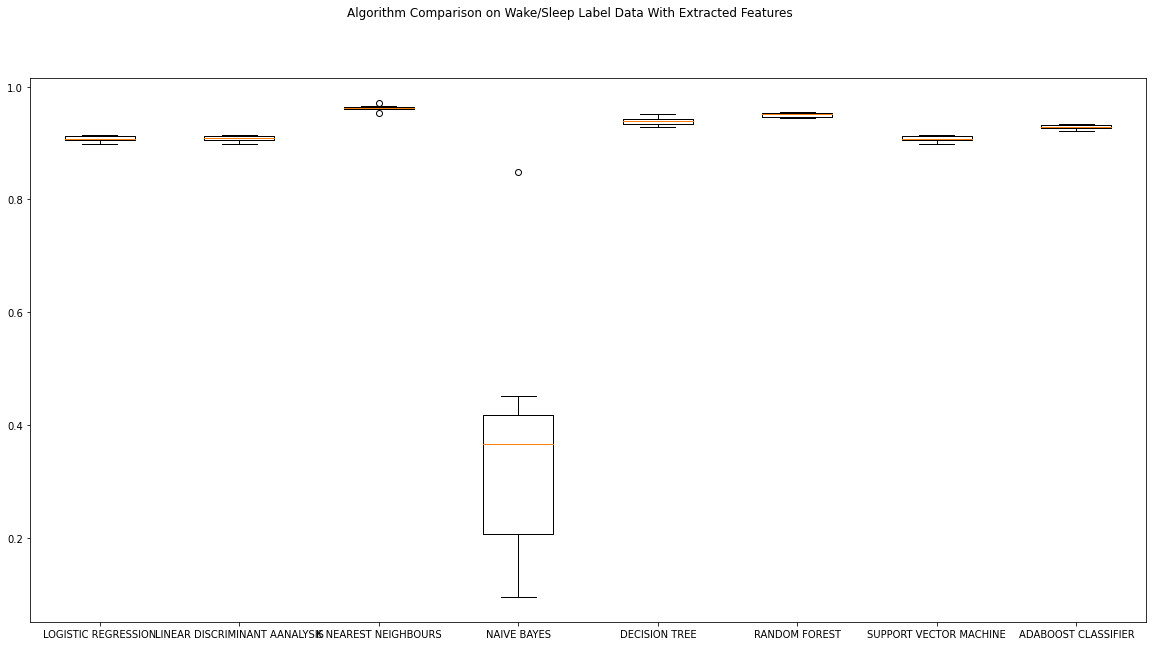

In [ ]:
plot_algo_comparison(names, results, title="Algorithm Comparison on Wake/Sleep Label Data With Extracted Features")

Classification on binary labelled data with extracted features yielded improved results in accuracy compared to that in the independent data point model earlier in the notebook. As shown, with the exception of Naive Bayes, all the algorithms displayed accuracy of above 90%. Decision Tree and Random Forest performed well again but K-nearest neighbours had the highest accuracy for this dataset with an accuracy of > 95%. Upon inspection of the confusion matrix, there is no indication of the model guessing "Sleep" for all data points as shown in the false predictions for "Wake".

## AutoML

In [ ]:
import autosklearn.classification
import sklearn
# configure auto-sklearn
automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          )

# train model(s)
automl.fit(X_train, y_train)

# evaluate
y_hat = automl.predict(X_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_hat)
print("Test Accuracy score {0}".format(test_acc))

Test Accuracy score 0.9538228614685844


# Three-Label Classifier
Now we are using the extracted feature set to classify based on the three label categories of Wake/Non-REM Sleep/REM Sleep and again assigning them the labels of 0/1/2 respectively

In [ ]:
e_three_label_array = extracted_labels['1'].ravel().copy()
e_three_label_array[(e_three_label_array == 1) | (e_three_label_array == 2) | (e_three_label_array == 3)] = 1
e_three_label_array[e_three_label_array == 5] = 2

print(np.unique(three_label_array))
print(three_label_array.shape)

[0 1 2]
(26417,)


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting our data into training and testing.

X_train, X_test, y_train, y_test = train_test_split(extracted_features, e_three_label_array, test_size=0.25)

## Decision Tree Classifier

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

scores = cross_val_score(clf, X_train, y_train, cv=5)
print('The mean score and the 95% confidence interval of the score estimate are given by:')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Training the model in a standard way allows to to view the feature importance
# for this model alone.
clf.fit(X_train,y_train)
importance = (clf.feature_importances_)

# using list comprehension + enumerate() 
# index of matching element 
res = [idx for idx, val in enumerate(importance) if val > 0] 
res_feats = [extracted_features.columns[i] for i in res]
  
# print result 
print("\nThe list of features with importance: ") 

print(res_feats)
#print("importance\n", importance)

The mean score and the 95% confidence interval of the score estimate are given by:
Accuracy: 0.88 (+/- 0.01)

The list of features with importance: 
['id', 'time', 'value__sum_values', 'value__abs_energy', 'value__mean_abs_change', 'value__mean_change', 'value__mean_second_derivative_central', 'value__median', 'value__mean', 'value__standard_deviation', 'value__variation_coefficient', 'value__variance', 'value__skewness', 'value__kurtosis', 'value__absolute_sum_of_changes', 'value__last_location_of_minimum', 'value__maximum', 'value__minimum', 'value__benford_correlation', 'value__time_reversal_asymmetry_statistic__lag_1', 'value__c3__lag_1', 'value__cid_ce__normalize_True', 'value__cid_ce__normalize_False', 'value__quantile__q_0.1', 'value__quantile__q_0.2', 'value__quantile__q_0.3', 'value__quantile__q_0.4', 'value__quantile__q_0.6', 'value__quantile__q_0.7', 'value__quantile__q_0.8', 'value__quantile__q_0.9', 'value__autocorrelation__lag_1', 'value__autocorrelation__lag_2', 'value__

## Nested Cross-Validation

In [ ]:
#nested_cross_val(X_train, y_train)

## Comparing Classification Algorithms

In [ ]:
names, results = algorithm_comparison(X_train, y_train, X_test, y_test)

Model  Mean Accuracy  95% conf interval
LOGISTIC REGRESSION: 0.6772655311228619 0.019951434662157083

Test set accuracy:
 0.6852384557153671 

Confusion Matrix
 [[   0  587    8]
 [   0 4497   67]
 [   0 1417   29]] 

Classification report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       595
           1       0.69      0.99      0.81      4564
           2       0.28      0.02      0.04      1446

    accuracy                           0.69      6605
   macro avg       0.32      0.34      0.28      6605
weighted avg       0.54      0.69      0.57      6605
 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
LINEAR DISCRIMINANT AANALYSIS: 0.6842815271822984 0.01975274575622416

Test set accuracy:
 0.6915972747918244 

Confusion Matrix
 [[   1  592    2]
 [   0 4561    3]
 [   0 1440    6]] 

Classification report
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       595
           1       0.69      1.00      0.82      4564
           2       0.55      0.00      0.01      1446

    accuracy                           0.69      6605
   macro avg       0.75      0.34      0.28      6605
weighted avg       0.69      0.69      0.57      6605
 

Model  Mean Accuracy  95% conf interval
K NEAREST NEIGHBOURS: 0.9225717983812922 0.009332787532341515

Test set accuracy:
 0.9262679788039364 

Confusion Matrix
 [[ 375  186   34]
 [  44 4401  119]
 [   4  100 1342]] 

Classification report
               precision    recall  f1-score   support

           0       0.89      0.63      0.74       595
           1    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
ADABOOST CLASSIFIER: 0.714616964085146 0.019613024246668487

Test set accuracy:
 0.7261165783497351 

Confusion Matrix
 [[ 216  343   36]
 [ 110 4336  118]
 [   6 1196  244]] 

Classification report
               precision    recall  f1-score   support

           0       0.65      0.36      0.47       595
           1       0.74      0.95      0.83      4564
           2       0.61      0.17      0.26      1446

    accuracy                           0.73      6605
   macro avg       0.67      0.49      0.52      6605
weighted avg       0.70      0.73      0.67      6605
 



## Plotting Algorithm Performance

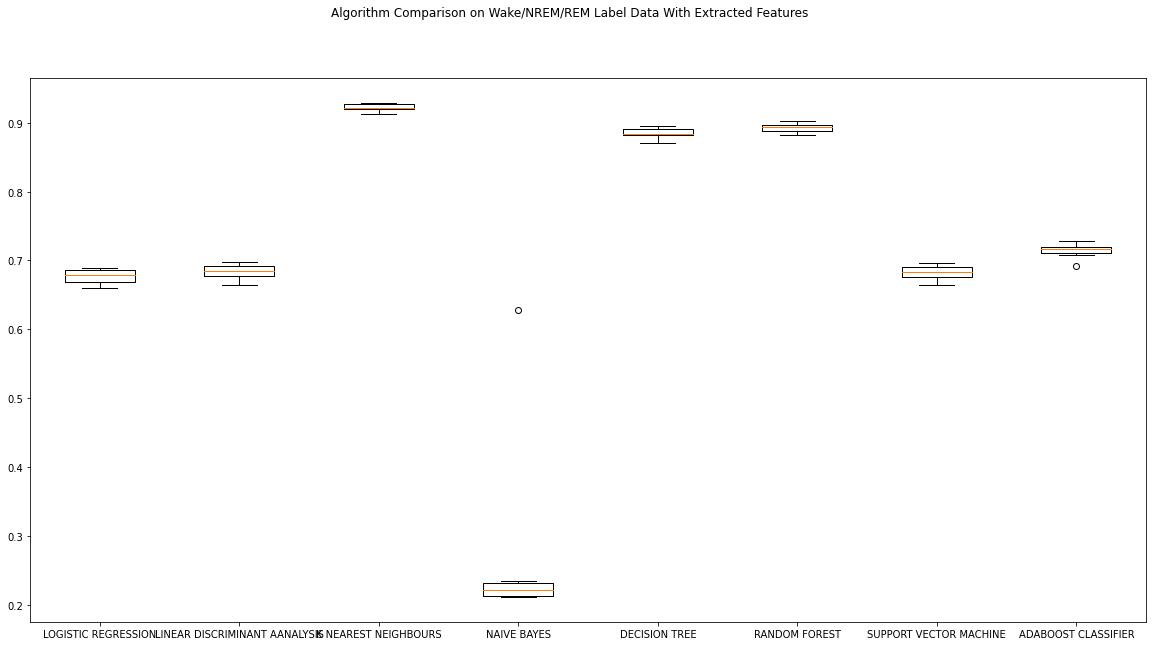

In [ ]:
plot_algo_comparison(names, results, title="Algorithm Comparison on Wake/NREM/REM Label Data With Extracted Features")

The models' accuracies decrease as another label is added to the classification. K-Nearest Neighbours is the only model to achieve an accuracy of > 0.9, with Decision Tree and RF closely following behind it.

## AutoML

In [ ]:
import autosklearn.classification
import sklearn
# configure auto-sklearn
automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          )

# train model(s)
automl.fit(X_train, y_train)

# evaluate
y_hat = automl.predict(X_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_hat)
print("Test Accuracy score {0}".format(test_acc))

[WARNING] [2020-11-20 13:17:10,991:AutoML(1):4a90586aeebb8ab627a0bcbde461d7de] No valid ensemble was created. Please check the logfile for errors. Default to the best individual estimator:[(1, 3, 0.0)]
Test Accuracy score 0.9015897047691143


# Multi-Label Classifier

In [ ]:
e_label_array = extracted_labels['1'].ravel()
print(e_label_array.shape)
np.unique(e_label_array)

(26417,)


array([0, 1, 2, 3, 5])

In [ ]:
extracted_features = extracted_features.dropna(axis='columns')
extracted_labels["1"].unique()

array([0, 1, 2, 3, 5])

In [ ]:
print("Extracted Features", "\n", extracted_features)
print("\nExtracted Labels", "\n", extracted_labels)

Extracted Features 
             id  ...  value__permutation_entropy__dimension_4__tau_1
0        46343  ...                                            -0.0
1        46343  ...                                            -0.0
2        46343  ...                                            -0.0
3        46343  ...                                            -0.0
4        46343  ...                                            -0.0
...        ...  ...                                             ...
26412  9961348  ...                                            -0.0
26413  9961348  ...                                            -0.0
26414  9961348  ...                                            -0.0
26415  9961348  ...                                            -0.0
26416  9961348  ...                                            -0.0

[26417 rows x 271 columns]

Extracted Labels 
             id   time  1
0        46343    390  0
1        46343    420  0
2        46343    450  0
3        46343 

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting our data into training and testing.

X_train, X_test, y_train, y_test = train_test_split(extracted_features, e_label_array, test_size=0.25)

## Decision Tree Classifier

Let's look at the feature importance according to this Decision Tree Model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

scores = cross_val_score(clf, X_train, y_train, cv=5)
print('The mean score and the 95% confidence interval of the score estimate are given by:')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Training the model in a standard way allows to to view the feature importance
# for this model alone.
clf.fit(X_train,y_train)
importance = (clf.feature_importances_)

# using list comprehension + enumerate() 
# index of matching element 
res = [idx for idx, val in enumerate(importance) if val > 0] 
res_feats = [extracted_features.columns[i] for i in res]
  
# print result 
print("\nThe list of features with importance: ") 

print(res_feats)
#print("importance\n", importance)

The mean score and the 95% confidence interval of the score estimate are given by:
Accuracy: 0.80 (+/- 0.02)

The list of features with importance: 
['id', 'time', 'value__sum_values', 'value__abs_energy', 'value__mean_abs_change', 'value__mean_change', 'value__mean_second_derivative_central', 'value__median', 'value__mean', 'value__standard_deviation', 'value__variation_coefficient', 'value__variance', 'value__skewness', 'value__kurtosis', 'value__absolute_sum_of_changes', 'value__last_location_of_minimum', 'value__first_location_of_minimum', 'value__maximum', 'value__minimum', 'value__benford_correlation', 'value__time_reversal_asymmetry_statistic__lag_1', 'value__c3__lag_1', 'value__cid_ce__normalize_True', 'value__cid_ce__normalize_False', 'value__quantile__q_0.1', 'value__quantile__q_0.2', 'value__quantile__q_0.3', 'value__quantile__q_0.4', 'value__quantile__q_0.6', 'value__quantile__q_0.7', 'value__quantile__q_0.8', 'value__quantile__q_0.9', 'value__autocorrelation__lag_1', 'valu

## Nested Cross Validation

In [ ]:
#nested_cross_val(X_train, y_train)

## Comparing Classification Algorithms

In [ ]:
names, results = algorithm_comparison(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Model  Mean Accuracy  95% conf interval
LOGISTIC REGRESSION: 0.4917209708171117 0.021632213103959075



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test set accuracy:
 0.48902346707040123 

Confusion Matrix
 [[   0    0  460  153    8]
 [   0    0  413   16    5]
 [   0    0 3090   67   74]
 [   0    0  774   87    0]
 [   0    0 1400    5   53]] 

Classification report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       621
           1       0.00      0.00      0.00       434
           2       0.50      0.96      0.66      3231
           3       0.27      0.10      0.15       861
           5       0.38      0.04      0.07      1458

    accuracy                           0.49      6605
   macro avg       0.23      0.22      0.17      6605
weighted avg       0.36      0.49      0.36      6605
 

Model  Mean Accuracy  95% conf interval
LINEAR DISCRIMINANT AANALYSIS: 0.49666819650453276 0.01435684270836671

Test set accuracy:
 0.49613928841786525 

Confusion Matrix
 [[  15    0  598    2    6]
 [   2    2  425    2    3]
 [   3    3 3224    0    1]
 [   0    0  855    6    0]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Mean Accuracy  95% conf interval
ADABOOST CLASSIFIER: 0.5070655842002556 0.02290260909353689

Test set accuracy:
 0.506888720666162 

Confusion Matrix
 [[ 160    9  334   16  102]
 [  36    8  273   25   92]
 [  73   14 2583  209  352]
 [   5    0  522  276   58]
 [  15    6 1054   62  321]] 

Classification report
               precision    recall  f1-score   support

           0       0.55      0.26      0.35       621
           1       0.22      0.02      0.03       434
           2       0.54      0.80      0.65      3231
           3       0.47      0.32      0.38       861
           5       0.35      0.22      0.27      1458

    accuracy                           0.51      6605
   macro avg       0.43      0.32      0.34      6605
weighted avg       0.47      0.51      0.46      6605
 



## Plotting Algorithm Performance

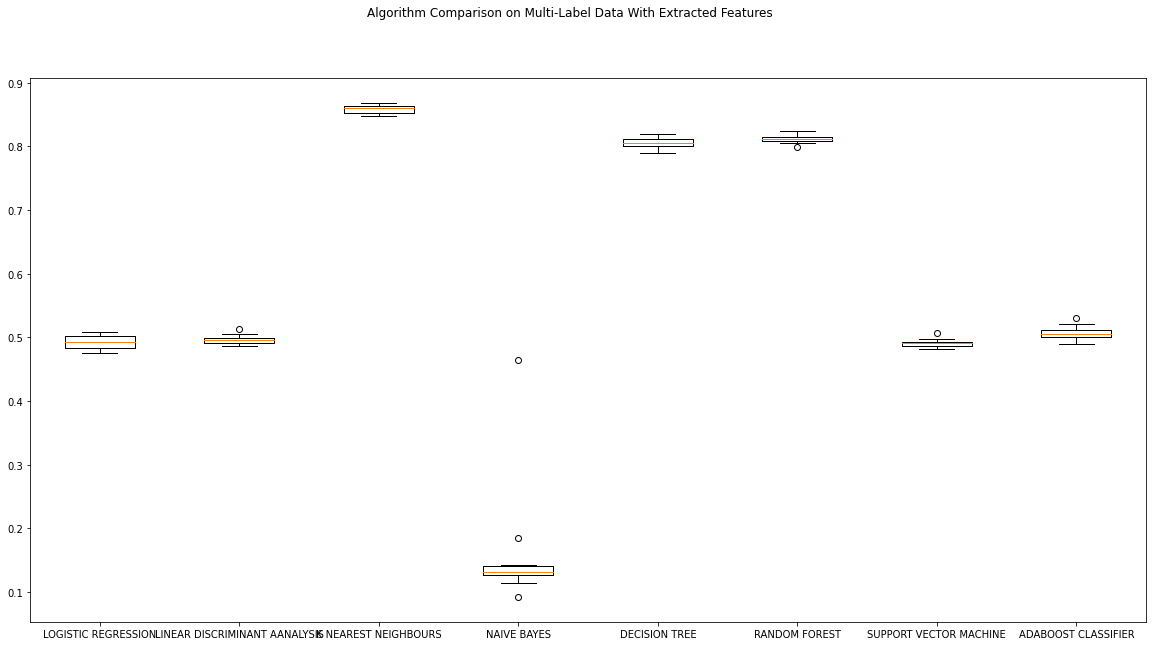

In [ ]:
plot_algo_comparison(names, results, title="Algorithm Comparison on Multi-Label Data With Extracted Features")

As expected, the models' accuracies deteriorate again with the inclusion of the full label to the classification. Again, Decision Tree and Random Forest return high accuracies of ~0.8 but K-Nearest Neighbours is the most accurate with a score of 0.86.

## AutoML

In [ ]:
import autosklearn.classification
import sklearn
# configure auto-sklearn
automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          )

# train model(s)
automl.fit(X_train, y_train)

# evaluate
y_hat = automl.predict(X_test)
test_acc = sklearn.metrics.accuracy_score(y_test, y_hat)
print("Test Accuracy score {0}".format(test_acc))

Test Accuracy score 0.09401968205904618


# Evaluation of Model Performances
As expected, we observe an improvement of model accuracy with addition of time series as opposed to taking each window as independent data points. An important note is that we acknowledge that the inclusion of patient ID in the time series classification model too but a look into feature significances still shows how important time is to the models. 
The models used can make an accurate prediction on sleep state given that window's motion and heart rate, but the information from all the data preceding it is very important in maximising model performance and returning high accuracy of predictions.

K-Nearest Neighbours was the best performing algorithm for the extracted feature data across two, three and five-label datasets. Benefits of this include that K-NN algorithm is very simple to understand and equally easy to implement. To classify the new data point K-NN algorithm reads through whole dataset to find out K nearest neighbors and classifies that point with the mode of the neighbours' labels. It's suitable for this assignment due to its ease to adjust to multi-class problems. KNN has no capability of handling missing information, which fortunately wasn't a problem in the datasets we used. Downsides to this model use is its speed and efficiency as the dataset grows. Generally, imbalanced data causes problems for this algorithm as the majority label is given prefernce leading to wrong predictions for the less common labels, but inspection of the confusion matrices of KNN shows that the predictions were quite balanced.